## Ice Volume Mesh Generation

In [1]:
from dolfinx.io import XDMFFile, gmshio
from mpi4py import MPI
import pandas as pd

import numpy as np

import dolfinx.plot as plot
from dolfinx.fem import Function, functionspace
from dolfinx.mesh import CellType, compute_midpoints, create_unit_cube, create_unit_square, meshtags

try:
    import pyvista
except ModuleNotFoundError:
    print("pyvista is required for this demo")
    exit(0)

# If environment variable PYVISTA_OFF_SCREEN is set to true save a png
# otherwise create interactive plot
if pyvista.OFF_SCREEN:
    pyvista.start_xvfb(wait=0.1)

# Set some global options for all plots
transparent = False
figsize = 800

try:
    import gmsh  # type: ignore
except ImportError:
    print("This demo requires gmsh to be installed")
    exit(0)

print('imports successful')

imports successful


## First let's grab our model input data

In [2]:
df = pd.read_csv(r"Fenics_model_data_2D.csv")

df.head()

,X,Y,X',Y',Surface,Bed,Thk,Surface Velocity,Gflux,Accumulation Rate,Basal Melt
0,-1.424760e+06,-309800.000000,0.000000,0.194918,1262.820000,-1195.708000,2458.528000,4.905400,94.582629,0.516792,-0.000002
1,-1.424292e+06,-309023.089711,0.003543,0.200799,1264.537784,-1262.322711,2526.860495,5.116135,94.639902,0.515100,-0.000005
2,-1.423824e+06,-308246.179421,0.007086,0.206681,1266.001130,-1320.864183,2586.865313,4.290588,94.697269,0.513402,-0.000007
3,-1.423356e+06,-307469.269132,0.010630,0.212563,1266.561462,-1268.223808,2534.785270,5.100441,94.754732,0.511926,-0.000007
4,-1.422888e+06,-306692.358843,0.014173,0.218445,1267.755947,-1196.717772,2464.473719,5.451651,94.812290,0.510527,-0.000006


In [3]:
X_prime = np.reshape(df["X'"],shape = (50,100))
Y_prime = np.reshape(df["Y'"],shape = (50,100))
Surface = np.reshape(df['Surface'],shape = (50,100))
Bed = np.reshape(df['Bed'],shape = (50,100))

# surf = pv.StructuredGrid(X_prime, Y_prime, Surface / Surface.max())
# bed = pv.StructuredGrid(X_prime, Y_prime, 1 + Bed / Bed.max())

## Next define our create_mesh function which, unsuprisingly, creates our mesh

In [4]:
def create_mesh(comm: MPI.Comm, model: gmsh.model, name: str, filename: str, mode: str):
    
    """Create a DOLFINx from a Gmsh model and output to file.

    Args:
        comm: MPI communicator top create the mesh on.
        model: Gmsh model.
        name: Name (identifier) of the mesh to add.
        filename: XDMF filename.
        mode: XDMF file mode. "w" (write) or "a" (append).
    """
    
    msh, ct, ft = gmshio.model_to_mesh(model, comm, rank=0)
    msh.name = name
    ct.name = f"{msh.name}_cells"
    ft.name = f"{msh.name}_facets"
    with XDMFFile(msh.comm, filename, mode) as file:
        msh.topology.create_connectivity(2, 3)
        file.write_mesh(msh)
        file.write_meshtags(
            ct, msh.geometry, geometry_xpath=f"/Xdmf/Domain/Grid[@Name='{msh.name}']/Geometry"
        )
        file.write_meshtags(
            ft, msh.geometry, geometry_xpath=f"/Xdmf/Domain/Grid[@Name='{msh.name}']/Geometry"
        )

In [5]:
gmsh.initialize()
gmsh.option.setNumber("General.Terminal", 0)

# Create model
model = gmsh.model()

## An Easy Example

In [16]:
def gmsh_sphere_minus_box(model: gmsh.model, name: str) -> gmsh.model:
    """Create a Gmsh model of a sphere with a box from the sphere removed.

    Args:
        model: Gmsh model to add the mesh to.
        name: Name (identifier) of the mesh to add.

    Returns:
        Gmsh model with a sphere mesh added.
    """
    model.add(name)
    model.setCurrent(name)

    sphere_dim_tags = model.occ.addSphere(0, 0, 0, 1)
    box_dim_tags = model.occ.addBox(0, 0, 0, 1, 1, 1)
    model_dim_tags = model.occ.cut([(3, sphere_dim_tags)], [(3, box_dim_tags)])
    model.occ.synchronize()

    # Add physical tag 1 for exterior surfaces
    boundary = model.getBoundary(model_dim_tags[0], oriented=False)
    boundary_ids = [b[1] for b in boundary]
    model.addPhysicalGroup(2, boundary_ids, tag=1)
    model.setPhysicalName(2, 1, "Sphere surface")

    # Add physical tag 2 for the volume
    volume_entities = [model[1] for model in model.getEntities(3)]
    model.addPhysicalGroup(3, volume_entities, tag=2)
    model.setPhysicalName(3, 2, "Sphere volume")

    model.mesh.generate(dim=3)
    return model

In [17]:
# Domain [-1,1]x[-1,0]x[-1,2] with 6x10x5 divisions mesh = Box(-1, -1, -1, 1, 0, 2, 6, 10, 5)
# mesh = Box(-1, -1, -1, 1, 0, 2, 6, 10, 5)

In [18]:
model = gmsh_sphere_minus_box(model, "Sphere minus box")
model.setCurrent("Sphere minus box")
create_mesh(MPI.COMM_WORLD, model, "ball_d1", "out_gmsh/mesh.xdmf", "w")

In [19]:
model.mesh.generate(3)
gmsh.option.setNumber("General.Terminal", 1)
model.mesh.setOrder(2)
gmsh.option.setNumber("General.Terminal", 0)
create_mesh(MPI.COMM_WORLD, model, "ball_d2", "out_gmsh/mesh.xdmf", "a")

Info    : Meshing order 2 (curvilinear on)...
Info    : [  0%] Meshing curve 1 order 2
Info    : [ 10%] Meshing curve 2 order 2
Info    : [ 20%] Meshing curve 3 order 2
Info    : [ 30%] Meshing curve 4 order 2
Info    : [ 30%] Meshing curve 5 order 2
Info    : [ 40%] Meshing curve 6 order 2
Info    : [ 50%] Meshing curve 7 order 2
Info    : [ 60%] Meshing curve 8 order 2
Info    : [ 60%] Meshing curve 9 order 2
Info    : [ 70%] Meshing surface 1 order 2
Info    : [ 80%] Meshing surface 2 order 2
Info    : [ 80%] Meshing surface 3 order 2
Info    : [ 90%] Meshing surface 4 order 2
Info    : [100%] Meshing volume 1 order 2
Info    : Surface mesh: worst distortion = 0.925932 (0 elements in ]0, 0.2]); worst gamma = 0.429526
Info    : Volume mesh: worst distortion = 0.875365 (0 elements in ]0, 0.2])
Info    : Done meshing order 2 (Wall 0.00302857s, CPU 0.00407s)


## Terrain Meshing: Modified Code from GMSH tutorial

In [6]:
# -----------------------------------------------------------------------------
#
#  Gmsh Python extended tutorial 2
#
#  Mesh import, discrete entities, hybrid models, terrain meshing
#
# -----------------------------------------------------------------------------

import gmsh
import sys
import math

# The API can be used to import a mesh without reading it from a file, by
# creating nodes and elements on the fly and storing them in model
# entities. These model entities can be existing CAD entities, or can be
# discrete entities, entirely defined by the mesh.
#
# Discrete entities can be reparametrized (see `t13.py') so that they can be
# remeshed later on; and they can also be combined with built-in CAD entities to
# produce hybrid models.
#
# We combine all these features in this tutorial to perform terrain meshing,
# where the terrain is described by a discrete surface (that we then
# reparametrize) combined with a CAD representation of the underground.

Surface_N = Surface / Surface.max()

gmsh.initialize()

gmsh.model.add("x2")

# We will create the terrain surface mesh from Nx x Ny input data points:
Nx = 50
Ny = 100

# Helper function to return a node tag given two indices i and j:
def tag(i, j):
    return i * (Ny + 1) + j + 1


# The x, y, z coordinates of all the nodes:
coords = []

# The tags of the corresponding nodes:
nodes = []

# The connectivities of the triangle elements (3 node tags per triangle) on the
# terrain surface:
tris = []

# The connectivities of the line elements on the 4 boundaries (2 node tags
# for each line element):
lin = [[], [], [], []]

# The connectivities of the point elements on the 4 corners (1 node tag for each
# point element):

pnt = [tag(0, 0), tag(Nx, 0), tag(Nx, Ny), tag(0, Ny)]

# # Quick pad using edge replication (if appropriate)
# Surface_pad = np.pad(Surface, ((0,1),(0,1)), mode='edge')
# X_pad = np.pad(X_prime, ((0,1),(0,1)), mode='edge')
# Y_pad = np.pad(Y_prime, ((0,1),(0,1)), mode='edge')

for i in range(Nx + 1):
    
    for j in range(Ny + 1):
        
        nodes.append(tag(i, j))
        
        coords.extend([
            float(i) / Nx,
            float(j) / Ny, 
            Surface_N[max(i - 1, 0), max(j - 1, 0)]
            
            # 0.05 * math.sin(10 * float(i + j) / Ny) # is this where the surface is defined?

            # make domain super small and do the math
        ])

        if (i == 1 and j == 1) or (i == Nx and j == Ny):
            print('Surface Value:',Surface_N[i - 1, j - 1])
            print('i:', i, '\n j:', j)
            print('Coords Z-Value',coords[3 * tag(i, j) - 1])
        
        if i > 0 and j > 0:
            tris.extend([tag(i - 1, j - 1), tag(i, j - 1), tag(i - 1, j)])
            tris.extend([tag(i, j - 1), tag(i, j), tag(i - 1, j)])
            
        if (i == 0 or i == Nx) and j > 0:
            lin[3 if i == 0 else 1].extend([tag(i, j - 1), tag(i, j)])
            
        if (j == 0 or j == Ny) and i > 0:
            lin[0 if j == 0 else 2].extend([tag(i - 1, j), tag(i, j)])

# Create 4 discrete points for the 4 corners of the terrain surface:
for i in range(4):
    gmsh.model.addDiscreteEntity(0, i + 1)

# print("coords length:", len(coords))
# print("total vertices:", len(coords)//3)
# print("Nx, Ny:", Nx, Ny)
# print("tag(0,0):", tag(0,0))
# print("tag(Nx, Ny):", tag(Nx, Ny))

gmsh.model.setCoordinates(1, 0, 0, coords[3 * tag(0, 0) - 1])

gmsh.model.setCoordinates(2, 1, 0, coords[3 * tag(Nx, 0) - 1])

gmsh.model.setCoordinates(3, 1, 1, coords[3 * tag(Nx, Ny) - 1])

gmsh.model.setCoordinates(4, 0, 1, coords[3 * tag(0, Ny) - 1])

# gmsh.model.setCoordinates(1, 0, 0, Surface_N[0,0])

# gmsh.model.setCoordinates(2, 1, 0, Surface_N[Nx - 1, 0])

# gmsh.model.setCoordinates(3, 1, 1, Surface_N[Nx - 1, Ny - 1])

# gmsh.model.setCoordinates(4, 0, 1, Surface_N[0, Ny - 1])

# Create 4 discrete bounding curves, with their boundary points:
for i in range(4):
    gmsh.model.addDiscreteEntity(1, i + 1, [i + 1, i + 2 if i < 3 else 1])

# Create one discrete surface, with its bounding curves:
gmsh.model.addDiscreteEntity(2, 1, [1, 2, 3, 4])

# Add all the nodes on the surface (for simplicity... see below):
gmsh.model.mesh.addNodes(2, 1, nodes, coords)

# Add point elements on the 4 points, line elements on the 4 curves, and
# triangle elements on the surface:
for i in range(4):
    
    # Type 15 for point elements:
    gmsh.model.mesh.addElementsByType(i + 1, 15, [], [pnt[i]])
    
    # Type 1 for 2-node line elements:
    gmsh.model.mesh.addElementsByType(i + 1, 1, [], lin[i])

# Type 2 for 3-node triangle elements:
gmsh.model.mesh.addElementsByType(1, 2, [], tris)

# Reclassify the nodes on the curves and the points (since we put them all on
# the surface before with `addNodes' for simplicity)
gmsh.model.mesh.reclassifyNodes()

# Create a geometry for the discrete curves and surfaces, so that we can remesh
# them later on:
gmsh.model.mesh.createGeometry()

# Note that for more complicated meshes, e.g. for on input unstructured STL
# mesh, we could use `classifySurfaces()' to automatically create the discrete
# entities and the topology; but we would then have to extract the boundaries
# afterwards.

# Create other build-in CAD entities to form one volume below the terrain
# surface. Beware that only built-in CAD entities can be hybrid, i.e. have
# discrete entities on their boundary: OpenCASCADE does not support this
# feature.

p1 = gmsh.model.geo.addPoint(0, 0, -0.5)
p2 = gmsh.model.geo.addPoint(1, 0, -0.5)
p3 = gmsh.model.geo.addPoint(1, 1, -0.5)
p4 = gmsh.model.geo.addPoint(0, 1, -0.5)
c1 = gmsh.model.geo.addLine(p1, p2)
c2 = gmsh.model.geo.addLine(p2, p3)
c3 = gmsh.model.geo.addLine(p3, p4)
c4 = gmsh.model.geo.addLine(p4, p1)
c10 = gmsh.model.geo.addLine(p1, 1)
c11 = gmsh.model.geo.addLine(p2, 2)
c12 = gmsh.model.geo.addLine(p3, 3)
c13 = gmsh.model.geo.addLine(p4, 4)
ll1 = gmsh.model.geo.addCurveLoop([c1, c2, c3, c4])
s1 = gmsh.model.geo.addPlaneSurface([ll1])
ll3 = gmsh.model.geo.addCurveLoop([c1, c11, -1, -c10])
s3 = gmsh.model.geo.addPlaneSurface([ll3])
ll4 = gmsh.model.geo.addCurveLoop([c2, c12, -2, -c11])
s4 = gmsh.model.geo.addPlaneSurface([ll4])
ll5 = gmsh.model.geo.addCurveLoop([c3, c13, 3, -c12])
s5 = gmsh.model.geo.addPlaneSurface([ll5])
ll6 = gmsh.model.geo.addCurveLoop([c4, c10, 4, -c13])
s6 = gmsh.model.geo.addPlaneSurface([ll6])
sl1 = gmsh.model.geo.addSurfaceLoop([s1, s3, s4, s5, s6, 1])
v1 = gmsh.model.geo.addVolume([sl1])
gmsh.model.geo.synchronize()

# Set this to True to build a fully hex mesh:
#transfinite = True
transfinite = False
transfiniteAuto = False

if transfinite:
    NN = 30
    for c in gmsh.model.getEntities(1):
        gmsh.model.mesh.setTransfiniteCurve(c[1], NN)
    for s in gmsh.model.getEntities(2):
        gmsh.model.mesh.setTransfiniteSurface(s[1])
        gmsh.model.mesh.setRecombine(s[0], s[1])
        gmsh.model.mesh.setSmoothing(s[0], s[1], 100)
    gmsh.model.mesh.setTransfiniteVolume(v1)
elif transfiniteAuto:
    gmsh.option.setNumber('Mesh.MeshSizeMin', 0.5)
    gmsh.option.setNumber('Mesh.MeshSizeMax', 0.5)
    # setTransfiniteAutomatic() uses the sizing constraints to set the number
    # of points
    gmsh.model.mesh.setTransfiniteAutomatic()
else:
    gmsh.option.setNumber('Mesh.MeshSizeMin', 0.05)
    gmsh.option.setNumber('Mesh.MeshSizeMax', 0.05)

print("Entities:", gmsh.model.getEntities())
print("Volumes:", gmsh.model.getEntities(3))
print("Surfaces:", gmsh.model.getEntities(2))
print("Curves:", gmsh.model.getEntities(1))
print("Points:", gmsh.model.getEntities(0))

gmsh.model.mesh.generate(3)
gmsh.write('test.msh')

# For all tetrahedra in volume v1
gmsh.model.addPhysicalGroup(3, [v1], tag=1)
gmsh.model.setPhysicalName(3, 1, "Volume")

# For surface triangles (if any)
surface_entities = [1, 2, 3, 4, 5, 6]  # replace with your surface IDs
gmsh.model.addPhysicalGroup(2, surface_entities, tag=1)
gmsh.model.setPhysicalName(2, 1, "Surface")

# Launch the GUI to see the results:
if '-nopopup' not in sys.argv:
    gmsh.fltk.run()

gmsh.finalize()

Surface Value: 0.875907100474463
i: 1 
 j: 1
Coords Z-Value 0.875907100474463
Surface Value: 0.9684459736250504
i: 50 
 j: 100
Coords Z-Value 0.9684459736250504
Info    : Creating geometry of discrete curves...
Info    : Done creating geometry of discrete curves (Wall 4.9768e-05s, CPU 0.001275s)
Info    : Creating geometry of discrete surfaces...
Entities: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1)]
Volumes: [(3, 1)]
Surfaces: [(2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6)]
Curves: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12)]
Points: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8)]
Info    : Done creating geometry of discrete surfaces (Wall 0.157471s, CPU 0.339785s)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Discrete curve)
Inf

X_ChangeProperty: BadValue (integer parameter out of range for operation) 0x0


In [67]:
## normals = []

gmsh.initialize()
gmsh.open("x2.msh")  # or your mesh filename
gmsh.model.setCurrent("x2")  # optional: ensure model name is correct

# Now you can access or modify the mesh:
entities = gmsh.model.getEntities()
print("Entities:", entities,'\n')

# gmsh.fltk.run()

# Filter only surfaces (dimension = 2)
surfaces = [e for e in entities if e[0] == 2]
print("\nSurface entities:", surfaces)


for e in gmsh.model.getEntities(2): 
    
    # Retrieve the surface tag 
    s = e[1]

    print(gmsh.model.getEntities(2))
    print(s)

    tags, coord, param = gmsh.model.mesh.getNodes(2, s, True)
    
    # Get the surface normals on all the points on the surface corresponding to 
    # the parametric coordinates of the nodes norm = gmsh.model.getNormal(s, param)
    norm = gmsh.model.getNormal(s, param)

    print(np.shape(norm))
    print(np.shape(coord))
    print(np.shape(param),'\n')

    # Store the normals so that we can display them as 
    # list-based post-processing views 
    # for i in range(0, len(coord) - 3, 3): 

        # print(i)
        # normals.append(coord[i]) 
        # normals.append(coord[i + 1]) 
        # normals.append(coord[i + 2])
    
        # normals.append(norm[i]) 
        # normals.append(norm[i + 1]) 
        # normals.append(norm[i + 2])

    # Create a list-based vector view on points to display the normals, and a scalar 
    # view on points to display the curvatures 
    # vn = gmsh.view.add("normals") 
    # gmsh.view.addListData(vn, "VP", len(normals) // 6, normals) 
    # gmsh.view.option.setNumber(vn, 'ShowScale', 0) 
    # gmsh.view.option.setNumber(vn, 'ArrowSizeMax', 30) 
    # gmsh.view.option.setNumber(vn, 'ColormapNumber', 19)

Info    : Reading 'x2.msh'...
Info    : 27 entities
Info    : 10787 nodes
Info    : 62970 elements
Info    : 1 parametrization
Info    : Done reading 'x2.msh'ametrizations                                                                                
Entities: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1)] 


Surface entities: [(2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6)]
[(2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6)]
1
(252,)
(1749,)
(168,) 

[(2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6)]
2
(240,)
(1539,)
(160,) 

[(2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6)]
3
(291,)
(2190,)
(194,) 

[(2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6)]
4
(297,)
(2286,)
(198,) 

[(2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6)]
5
(303,)
(2328,)
(202,) 

[(2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6)]
6
(297,)
(2271,)
(198,) 

In [71]:
import sys
import math

gmsh.initialize(sys.argv)

# The API provides access to geometrical data in a CAD kernel agnostic manner.

# Let's create a simple CAD model by fusing a sphere and a cube, then mesh the surfaces:
gmsh.model.add("x5")
s = gmsh.model.occ.addSphere(0, 0, 0, 1)
b = gmsh.model.occ.addBox(0.5, 0, 0, 1.3, 2, 3)
gmsh.model.occ.fuse([(3, s)], [(3, b)])
gmsh.model.occ.synchronize()
gmsh.model.mesh.generate(2)

# We can for example retrieve the exact normals and the curvature at all the mesh nodes
# (i.e. not normals and curvatures computed from the mesh, but directly evaluated on the geometry)
# by querying the CAD kernels at the corresponding parametric coordinates.
normals = []
curvatures = []

for e in gmsh.model.getEntities(2):
    # Retrieve the surface tag
    s = e[1]

    # Get the mesh nodes on the surface, including those on the boundary
    # Contrary to internal nodes, which store their parametric coordinates,
    # boundary nodes will be reparameterized on the surface in order to compute
    # their parametric coordinates; the result being different when
    # reparameterized on another adjacent surface.
    tags, coord, param = gmsh.model.mesh.getNodes(2, s, True)

    # Get the surface normals on all the points on the surface corresponding to
    # the parametric coordinates of the nodes
    norm = gmsh.model.getNormal(s, param)

    # In the same way, get the curvature
    curv = gmsh.model.getCurvature(2, s, param)

    print(np.shape(norm),'\n')
    print(np.shape(coords))

    # Store the normals and the curvatures so that we can display them as
    # list-based post-processing views
    normals = []
    curvatures = []

    for i in range(0, len(coord), 3):
        normals.append(coord[i])
        normals.append(coord[i + 1])
        normals.append(coord[i + 2])
        normals.append(norm[i])
        normals.append(norm[i + 1])
        normals.append(norm[i + 2])

        curvatures.append(coord[i])
        curvatures.append(coord[i + 1])
        curvatures.append(coord[i + 2])
        curvatures.append(curv[i // 3])

    # Create a list-based vector view on points to display the normals,
    # and a scalar view on points to display the curvature
    vn = gmsh.view.add("normals")
    gmsh.view.addListData(vn, "VP", len(normals) // 6, normals)
    gmsh.view.option.setNumber(vn, "ShowScale", 0)
    gmsh.view.option.setNumber(vn, "ArrowSizeMax", 30)
    gmsh.view.option.setNumber(vn, "ColormapNumber", 19)

    vc = gmsh.view.add("curvature")
    gmsh.view.addListData(vc, "SP", len(curvatures) // 4, curvatures)
    gmsh.view.option.setNumber(vc, "ShowScale", 1)

# Retrieve the parametrization bounds of model entities, e.g., curve 5,
# and evaluate the parametrization for several parameter values
bounds = gmsh.model.getParametrizationBounds(1, 5)
N = 20
# t = [bounds[0][0] + i * (bounds[0][1] - bounds[0][0]) / N for i in range(N + 1)]
# xyz1 = gmsh.model.getValue(1, 5, t)

# Example: we can also reparametrize curve 5 on surface 1 and evaluate
# the points in the parametric plane of the surface

# Launch the GUI to see the results:
if '-nopopup' not in sys.argv:
    gmsh.fltk.run()

gmsh.finalize()

Error   : Unknown mesh format '/home/jbott/.local/share/jupyter/runtime/kernel-e5c7aba5-0343-4149-ac4b-71c0e4f111cb.json'


Info    : Meshing 1D...                                                                                 
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 10%] Meshing curve 2 (Circle)
Info    : [ 20%] Meshing curve 3 (Circle)
Info    : [ 30%] Meshing curve 5 (Circle)
Info    : [ 30%] Meshing curve 6 (Circle)
Info    : [ 40%] Meshing curve 8 (Line)
Info    : [ 50%] Meshing curve 9 (Line)
Info    : [ 50%] Meshing curve 10 (Line)
Info    : [ 60%] Meshing curve 11 (Line)
Info    : [ 60%] Meshing curve 12 (Line)
Info    : [ 70%] Meshing curve 13 (Line)
Info    : [ 70%] Meshing curve 14 (Line)
Info    : [ 80%] Meshing curve 15 (Line)
Info    : [ 80%] Meshing curve 16 (Line)
Info    : [ 90%] Meshing curve 17 (Line)
Info    : [ 90%] Meshing curve 18 (Line)
Info    : [100%] Meshing curve 19 (Line)
Info    : Done meshing 1D (Wall 0.00105801s, CPU 0.001732s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Sphere, Frontal-Delaunay)
Info    : [ 20%] Meshing surface 2 (Plane, Fronta

In [16]:
print(coords[3 * tag(0, 0) - 1])
print(Surface_N[0,0])
print('\n')

print(coords[3 * tag(Nx, 0) - 1])
print(Surface_N[1,0])
print('\n')

print(coords[3 * tag(0, Ny) - 1])
print(Surface_N[0,1])
print('\n')

# print(coords[3 * tag(Nx, Ny) - 1])
# print(Surface_N[1,1])
# print('\n')

Surface_new = Surface_N[:,50:100]
np.shape(Surface_new)

0.9368823756092061
0.875907100474463


0.9368823756092061
0.8733537586815431


0.9487986128660073
0.8770985761222876




(50, 50)

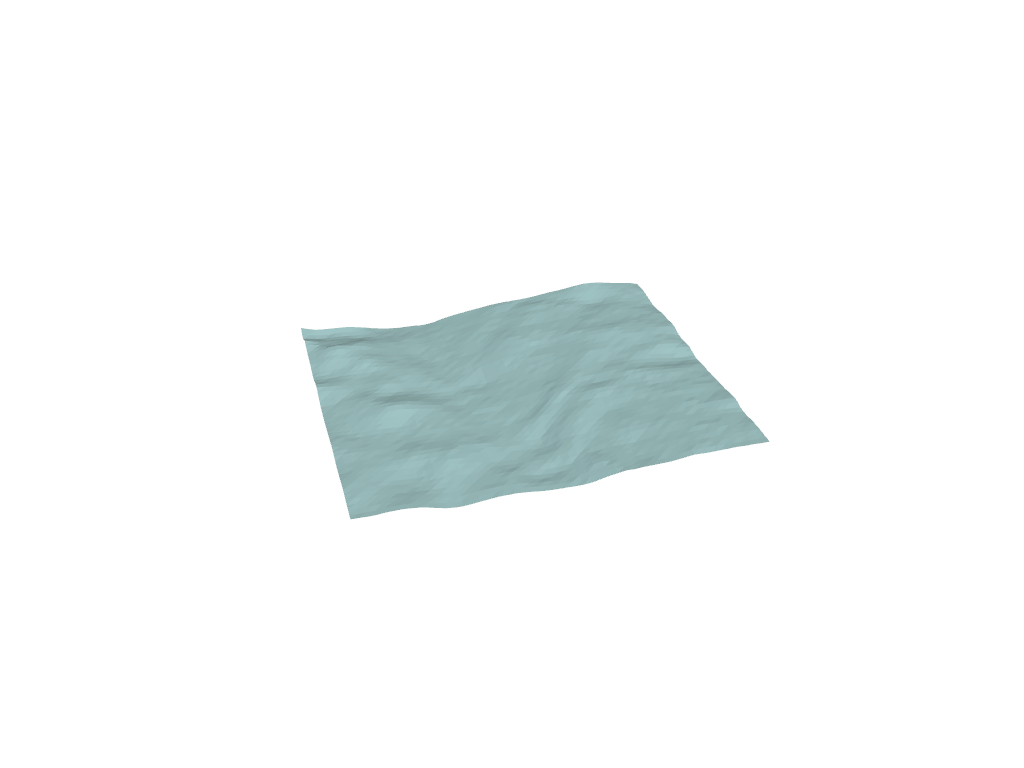

In [17]:
import pyvista as pv

# Create a structured grid
grid = pv.StructuredGrid(X_prime[:,50:100], Y_prime[:,50:100], Surface_new)

# Plot it
plotter = pv.Plotter()
plotter.add_mesh(grid, cmap='viridis', show_edges=False)
plotter.show()

In [18]:
# -----------------------------------------------------------------------------
#
#  Gmsh Python extended tutorial 2
#
#  Mesh import, discrete entities, hybrid models, terrain meshing
#
# -----------------------------------------------------------------------------

import gmsh
import sys
import math

# The API can be used to import a mesh without reading it from a file, by
# creating nodes and elements on the fly and storing them in model
# entities. These model entities can be existing CAD entities, or can be
# discrete entities, entirely defined by the mesh.
#
# Discrete entities can be reparametrized (see `t13.py') so that they can be
# remeshed later on; and they can also be combined with built-in CAD entities to
# produce hybrid models.
#
# We combine all these features in this tutorial to perform terrain meshing,
# where the terrain is described by a discrete surface (that we then
# reparametrize) combined with a CAD representation of the underground.

gmsh.initialize()

gmsh.model.add("x2")

# We will create the terrain surface mesh from N x N input data points:
N = 50


# Helper function to return a node tag given two indices i and j:
def tag(i, j):
    return (N + 1) * i + j + 1


# The x, y, z coordinates of all the nodes:
coords = []

# The tags of the corresponding nodes:
nodes = []

# The connectivities of the triangle elements (3 node tags per triangle) on the
# terrain surface:
tris = []

# The connectivities of the line elements on the 4 boundaries (2 node tags
# for each line element):
lin = [[], [], [], []]

# The connectivities of the point elements on the 4 corners (1 node tag for each
# point element):
pnt = [tag(0, 0), tag(N, 0), tag(N, N), tag(0, N)]

for i in range(N + 1):
    for j in range(N + 1):
        nodes.append(tag(i, j))

        print(i ,j)
        
        coords.extend([
            float(i) / N,
            float(j) / N,
            Surface_new[i - 1, j - 1]
            # 0.05 * math.sin(10 * float(i + j) / N)
        ])
        
        if i > 0 and j > 0:
            
            tris.extend([tag(i - 1, j - 1), tag(i, j - 1), tag(i - 1, j)])
            tris.extend([tag(i, j - 1), tag(i, j), tag(i - 1, j)])
            
        if (i == 0 or i == N) and j > 0:
            lin[3 if i == 0 else 1].extend([tag(i, j - 1), tag(i, j)])
            
        if (j == 0 or j == N) and i > 0:
            lin[0 if j == 0 else 2].extend([tag(i - 1, j), tag(i, j)])

print("coords length:", len(coords))
print("total vertices:", len(coords)//3)
print("N, N:", N, N)
print(3 * tag(N, N) - 1)
print("tag(0,0):", tag(0,0))
print("tag(N, N):", tag(N, N))

# Create 4 discrete points for the 4 corners of the terrain surface:
for i in range(4):
    gmsh.model.addDiscreteEntity(0, i + 1)
    
gmsh.model.setCoordinates(1, 0, 0, coords[3 * tag(0, 0) - 1])
gmsh.model.setCoordinates(2, 1, 0, coords[3 * tag(N, 0) - 1])
gmsh.model.setCoordinates(3, 1, 1, coords[3 * tag(N, N) - 1])
gmsh.model.setCoordinates(4, 0, 1, coords[3 * tag(0, N) - 1])

# Create 4 discrete bounding curves, with their boundary points:
for i in range(4):
    gmsh.model.addDiscreteEntity(1, i + 1, [i + 1, i + 2 if i < 3 else 1])

# Create one discrete surface, with its bounding curves:
gmsh.model.addDiscreteEntity(2, 1, [1, 2, -3, -4])

# Add all the nodes on the surface (for simplicity... see below):
gmsh.model.mesh.addNodes(2, 1, nodes, coords)

# Add point elements on the 4 points, line elements on the 4 curves, and
# triangle elements on the surface:
for i in range(4):
    # Type 15 for point elements:
    gmsh.model.mesh.addElementsByType(i + 1, 15, [], [pnt[i]])
    # Type 1 for 2-node line elements:
    gmsh.model.mesh.addElementsByType(i + 1, 1, [], lin[i])
# Type 2 for 3-node triangle elements:
gmsh.model.mesh.addElementsByType(1, 2, [], tris)

# Reclassify the nodes on the curves and the points (since we put them all on
# the surface before with `addNodes' for simplicity)
gmsh.model.mesh.reclassifyNodes()

# Create a geometry for the discrete curves and surfaces, so that we can remesh
# them later on:
gmsh.model.mesh.createGeometry()

# Note that for more complicated meshes, e.g. for on input unstructured STL
# mesh, we could use `classifySurfaces()' to automatically create the discrete
# entities and the topology; but we would then have to extract the boundaries
# afterwards.

# Create other build-in CAD entities to form one volume below the terrain
# surface. Beware that only built-in CAD entities can be hybrid, i.e. have
# discrete entities on their boundary: OpenCASCADE does not support this
# feature.
p1 = gmsh.model.geo.addPoint(0, 0, -0.5)
p2 = gmsh.model.geo.addPoint(1, 0, -0.5)
p3 = gmsh.model.geo.addPoint(1, 1, -0.5)
p4 = gmsh.model.geo.addPoint(0, 1, -0.5)
c1 = gmsh.model.geo.addLine(p1, p2)
c2 = gmsh.model.geo.addLine(p2, p3)
c3 = gmsh.model.geo.addLine(p3, p4)
c4 = gmsh.model.geo.addLine(p4, p1)
c10 = gmsh.model.geo.addLine(p1, 1)
c11 = gmsh.model.geo.addLine(p2, 2)
c12 = gmsh.model.geo.addLine(p3, 3)
c13 = gmsh.model.geo.addLine(p4, 4)
ll1 = gmsh.model.geo.addCurveLoop([c1, c2, c3, c4])
s1 = gmsh.model.geo.addPlaneSurface([ll1])
ll3 = gmsh.model.geo.addCurveLoop([c1, c11, -1, -c10])
s3 = gmsh.model.geo.addPlaneSurface([ll3])
ll4 = gmsh.model.geo.addCurveLoop([c2, c12, -2, -c11])
s4 = gmsh.model.geo.addPlaneSurface([ll4])
ll5 = gmsh.model.geo.addCurveLoop([c3, c13, 3, -c12])
s5 = gmsh.model.geo.addPlaneSurface([ll5])
ll6 = gmsh.model.geo.addCurveLoop([c4, c10, 4, -c13])
s6 = gmsh.model.geo.addPlaneSurface([ll6])
sl1 = gmsh.model.geo.addSurfaceLoop([s1, s3, s4, s5, s6, 1])
v1 = gmsh.model.geo.addVolume([sl1])
gmsh.model.geo.synchronize()

# Set this to True to build a fully hex mesh:
#transfinite = True
transfinite = False
transfiniteAuto = False

if transfinite:
    NN = 30
    for c in gmsh.model.getEntities(1):
        gmsh.model.mesh.setTransfiniteCurve(c[1], NN)
    for s in gmsh.model.getEntities(2):
        gmsh.model.mesh.setTransfiniteSurface(s[1])
        gmsh.model.mesh.setRecombine(s[0], s[1])
        gmsh.model.mesh.setSmoothing(s[0], s[1], 100)
    gmsh.model.mesh.setTransfiniteVolume(v1)
elif transfiniteAuto:
    gmsh.option.setNumber('Mesh.MeshSizeMin', 0.5)
    gmsh.option.setNumber('Mesh.MeshSizeMax', 0.5)
    # setTransfiniteAutomatic() uses the sizing constraints to set the number
    # of points
    gmsh.model.mesh.setTransfiniteAutomatic()
else:
    gmsh.option.setNumber('Mesh.MeshSizeMin', 0.05)
    gmsh.option.setNumber('Mesh.MeshSizeMax', 0.05)

gmsh.model.mesh.generate(3)
gmsh.write('x2.msh')

# Launch the GUI to see the results:
if '-nopopup' not in sys.argv:
    gmsh.fltk.run()

gmsh.finalize()

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
2 30
2 31
2 32
2 33
2 34
2 35
2 36
2 37
2 38
2 39
2 40
2 41
2 42
2 43
2 44
2 45
2 46
2 47
2 48
2 49
2 50
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
3 17
3 18
3 19
3 20
3 21
3 22
3 23
3 24
3 25
3 26
3 27
3 28
3 29
3 30
3 31
3 32
3 33
3 34
3 35
3 36
3 37
3 38
3 39
3 40
3 41
3 42
3 43
3 44
3 45
3 46
3 47
3 48
3 49
3 50
4 0
4 1
4 2
4 3
4 4


X_ChangeProperty: BadValue (integer parameter out of range for operation) 0x0


In [21]:
print(coords[3 * tag(0, 0) - 1])
# print(Surface_N[0,0])
print('\n')

print(coords[3 * tag(Nx, 0) - 1])
# print(Surface_N[1,0])
print('\n')

print(coords[3 * tag(0, Ny) - 1])
# print(Surface_N[0,1])
print('\n')

print(coords[3 * tag(Nx, Ny) - 1])
# print(Surface_N[1,1])
print('\n')

0.0


-0.047946213733156925


-0.02720105554446849


0.032514392007855844




In [ ]:
# #!/usr/bin/env python3

# """
# Created on Thu Sep 23 10:22:22 2021

# Reads in relief.stl and meshes the volume between the relief and a z-coordinate specified in the script. 
# In addition it creates physical groups for all bounding surfaces.

# @author: dominik

# This script is derived from the gmsh-demo   terrain_stl.py
# Requirements: relief.stl (possibly converted from relief.grd)
# It is assumed that curves and points of read-in boundary are ordered.

# TO-DO
#     - N-E-S-W instead of front/left/...
#     - use transfinite curves/surfaces/volumes to create a hex-mesh
#     - make class for SIDES
#     - try to detect side points automatically from stl
# """
# import math
# import sys
# from pathlib import Path

# import gmsh
# import numpy as np

# dim1 = 1
# dim2 = 2
# dim3 = 3
# EPS = 1e-6  # for collinearity check,
# MIN_SIZE = 0.01  # minimum element size
# MAX_SIZE = 0.05  # maximum elemenz size

# # side definitions (straight lines), points chosen outside to prevent
# # collocation
# # X0 = 0
# # X1 = 10

# DX_1 = 0.00354
# DY_1 = 0.00588

# DX_2 =  0.00398
# DY_2 =  0.00569


# # Z = -1  # bottom_level

# X_bottom_left = X_prime[0,0]
# Y_bottom_left = Y_prime[0,0]

# X_bottom_right = X_prime[-1,0]
# Y_bottom_right = Y_prime[-1,0]

# X_top_right = X_prime[-1,-1]
# Y_top_right = Y_prime[-1,-1]

# X_top_left = X_prime[0,-1]
# Y_top_left = Y_prime[0,-1]

# Z = -2

# side_points = {
#     "front": {"p1": np.array([X_bottom_right - DX_1, Y_bottom_left - DY_1]), "p2": np.array([X_top_right + DX_1, Y_top_right + DY_1])}, # bottom right to top right
#     "right": {"p1": np.array([X_top_left - DX_2, Y_top_left + DY_2]), "p2": np.array([X_top_right + DX_2, Y_top_right - DY_2])}, # top left to top right
#     "back": {"p1": np.array([X_bottom_left - DX_1, Y_bottom_left - DY_1]), "p2": np.array([X_top_left + DX_1, Y_top_left + DY_1])}, # bottom left to top left
#     "left": {"p1": np.array([X_bottom_left - DX_2, Y_bottom_left + DY_2]), "p2": np.array([X_bottom_right + DX_2, Y_bottom_right - DY_2])}, # bottom left to bottom right
# }  

# # a line is defined by two points: p1 (x,y), p2 (x,y)

# side_surface_ids: dict[str, list[int]] = {
#     "front": [],
#     "right": [],
#     "back": [],
#     "left": [],
# }


# def collinear2D(p0, p1, p2):  #
#     x1, y1 = p0[0] - p1[0], p0[1] - p1[1]
#     x2, y2 = p2[0] - p0[0], p2[1] - p0[1]
#     CROSS_PRODUCT = x1 * y2 - x2 * y1
#     print(f"p0-p1=[{x1}, {y1}]")
#     print(f"p2-p0=[{x2}, {y2}]")
#     print(CROSS_PRODUCT)
#     return abs(CROSS_PRODUCT) < EPS


# def on_line2D(xyz, guess):
#     p0 = np.array([xyz[0], xyz[1]])
#     print(p0)
#     points = side_points[guess]
#     if collinear2D(p0, points["p1"], points["p2"]):
#         return guess
#     for side, points in side_points.items():
#         print(side)
#         if collinear2D(p0, points["p1"], points["p2"]):
#             return side
#     print("point " + str(p0) + " not on a given side")
#     return "NO SIDE FOUND"


# gmsh.initialize(sys.argv)  # use finalize to unload from memory

# # load an STL surface
# # path = r"\\wsl.localhost\Ubuntu\home\jbott\FEniCS"
# gmsh.merge(r"/home/jbott/FEniCS/normal_surface_1.stl")

# # classify the surface mesh according to given angle, and create discrete model
# # entities (surfaces, curves and points) accordingly; curveAngle forces bounding
# # curves to be split on sharp corners
# gmsh.model.mesh.classifySurfaces(
#     math.pi, curveAngle = math.pi
# )  

# # angle, boundary = True, forReparametrization = False, curveAngle = pi
# # angle=pi, selects the surface as one, no matter what angles are between the
# # STL-patches
# # curveAngle=0 selects each STL line segment as curve, even if they continue in
# # the same direction

# # create a geometry for the discrete curves and surfaces
# gmsh.model.mesh.createGeometry()

# # retrieve the surface, its boundary curves and corner points
# top_surfaces = gmsh.model.getEntities(2)  # discrete surface
# if len(top_surfaces) == 1:
#     top_surface = top_surfaces[0]
# else:
#     print("More than one top surface detected.")
#     gmsh.finalize()
#     sys.exit()

# top_curves = gmsh.model.getEntities(1)  # discrete surface
# top_points = gmsh.model.getEntities(0)  # discrete surface

# # create geometric entities to form one volume below the terrain surface
# bottom_point_ids = []
# side_curve_ids = []  # vertical lines
# for top_point in top_points:
#     xyz = gmsh.model.getValue(0, top_point[1], [])  # get x,y,z coordinates
#     bottom_point_id = gmsh.model.geo.addPoint(xyz[0], xyz[1], Z)
#     bottom_point_ids.append(bottom_point_id)
#     side_curve_id = gmsh.model.geo.addLine(bottom_point_id, top_point[1])
#     side_curve_ids.append(side_curve_id)
# gmsh.model.geo.synchronize()

# Nc = len(top_curves)
# bottom_curve_ids = []  # horizontal lines

# guessed_side = "left"
# for ci, top_curve in enumerate(top_curves):
#     cip1 = (ci + 1) % Nc  # switch to next and from last to first (cycle)
#     # get x,y,z coordinates
#     xyz_i = gmsh.model.getValue(0, bottom_point_ids[ci], [])
#     xyz_ip1 = gmsh.model.getValue(
#         0, bottom_point_ids[cip1], []
#     )  
    
#     # get x,y,z coordinates
#     xyz = 0.5 * (xyz_i + xyz_ip1)  # midpoint
#     detected_side = on_line2D(xyz, guessed_side)
#     if detected_side not in side_points:
#         print("Geometry error")
#         gmsh.finalize()
#         sys.exit()
#     else:
#         guessed_side = detected_side  # next guess

#     bottom_curve_id = gmsh.model.geo.addLine(
#         bottom_point_ids[ci], bottom_point_ids[cip1]
#     )
    
#     bottom_curve_ids.append(bottom_curve_id)
#     side_ll = gmsh.model.geo.addCurveLoop(
#         [
#             bottom_curve_id,
#             side_curve_ids[cip1],
#             -top_curve[1],
#             -side_curve_ids[ci],
#         ]
#     )
#     side_surface_id = gmsh.model.geo.addPlaneSurface([side_ll])
#     side_surface_ids[detected_side].append(side_surface_id)

# bottom_ll = gmsh.model.geo.addCurveLoop(bottom_curve_ids)
# bottom_surface_id = gmsh.model.geo.addPlaneSurface([bottom_ll])

# all_side_ids = []
# for surface_ids in side_surface_ids.values():
#     all_side_ids += surface_ids

# surface_loop1 = gmsh.model.geo.addSurfaceLoop(
#     [top_surface[1]] + all_side_ids + [bottom_surface_id]
# )
# volume1 = gmsh.model.geo.addVolume([surface_loop1])

# gmsh.model.geo.synchronize()

# # physical groups
# Top_Surface = gmsh.model.addPhysicalGroup(dim2, [top_surface[1]])
# gmsh.model.setPhysicalName(dim2, Top_Surface, "top")

# Bottom_Surface = gmsh.model.addPhysicalGroup(dim2, [bottom_surface_id])
# gmsh.model.setPhysicalName(dim2, Bottom_Surface, "bottom")

# for side in side_surface_ids:
#     Side_Surface = gmsh.model.addPhysicalGroup(dim2, side_surface_ids[side])
#     gmsh.model.setPhysicalName(dim2, Side_Surface, side)

# Volume1 = gmsh.model.addPhysicalGroup(dim3, [volume1])
# gmsh.model.setPhysicalName(dim3, Volume1, "volume")

# # meshing

# gmsh.option.setNumber("Mesh.MeshSizeMin", MIN_SIZE)
# gmsh.option.setNumber("Mesh.MeshSizeMax", MAX_SIZE)
# gmsh.model.mesh.generate(3)
# gmsh.write("gmsh_test_terrain_1.msh")

# # gmsh.fltk.run()   # GUI
# gmsh.finalize()  # to remove all objects from memory

In [1]:
# print("point 1:",X_prime[0,0],',',Y_prime[0,1],'\n')
# print("point 2:",X_prime[0,1],',',Y_prime[0,1],'\n')

# print("rise:", Y_prime[0,1] - Y_prime[0,0])
# print("run", X_prime[0,1] - X_prime[0,0],'\n')

# print("dy:", np.sqrt((Y_prime[0,1] - Y_prime[0,0])**2 + (X_prime[0,1] - X_prime[0,0])**2))